In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster, datasets, mixture

# Spis Treści
1. [Metoda K-średnich](#kmeans)
    1. [Powtórka](#kmeans)
    2. [Mini Batch K-means](#mbkmeans)
    3. [Zadanie](#kmeans_task)
2. [DBSCAN](#DBSCAN)
    1. [Teoria](#DBSCAN)
    2. [Przykład](#DBSCAN_example)
    3. [Zadanie](#DBSCAN_task)
    4. [Źródła](#DBSCAN_sources)
3. [GMM](#GMM)
    1. [Teoria](#GMM)
    2. [Przykład](#GMM_example)
    3. [Zadanie](#GMM_task)
    4. [Źródła](#GMM_sources)
4. [Standaryzacja (3D)](#standardization)

Przygotowanie danych:

In [2]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)
hide_toggle()


In [3]:
# Przygotowanie danych
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)
X_batch_blobs, y_batch_blobs= datasets.make_blobs(n_samples=[int(x) for x in np.linspace(1000, 21000, 11)], random_state=8, center_box=(-100, 100), cluster_std=np.linspace(1, 5, 11))

hide_toggle()

## Metoda K-średnich <a name="kmeans"></a>




Przypomnienie:  
![](https://miro.medium.com/max/960/1*KrcZK0xYgTa4qFrVr0fO2w.gif)
<div align="center">Żródło: https://towardsdatascience.com/the-5-clustering-algorithms-data-scientists-need-to-know-a36d136ef68</div>

<details>
<summary>Zalety?</summary>
    
   - niska złożoność, a co za tym idzie wysoka wydajność działania,
    
   - działa szybko przy dużych zbiorach i niskich ilościach grup,
    
   - pogrupowane zbiory są z reguły bardziej ciaśniejsze i zbite.
</details>

<details>
<summary>Wady?</summary>
    
   - nie pomaga w określeniu ilości grup (K),
    
   - różne wartości początkowe prowadzą do różnych wyników,
    
   - działa dobrze tylko dla „sferycznych” skupisk o jednorodnej gęstości.
</details>

<details>
<summary>Pytania - co możemy poprawić?</summary>
    
   - Co zrobić jeśli mamy bardzo dużo danych?
   
   - Co jeśli dane nie są sferyczne?
   
   - Może automatyczna detekcja liczby skupień?
</details>

### Metoda Mini Batch <a name="mbkmeans"></a>

In [4]:
len(X_batch_blobs[:,0])

121000

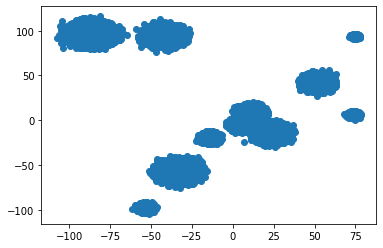

In [5]:
plt.scatter(X_batch_blobs[:,0], X_batch_blobs[:,1])
plt.show()

In [6]:
def _KMeans(X, n_clusters):
    kmeans = cluster.KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(X)
    return X, kmeans

def _MiniBatchKMeans(X, n_clusters):
    miniBatchKmeans = cluster.MiniBatchKMeans(n_clusters=n_clusters)
    miniBatchKmeans.fit(X)
    return X, miniBatchKmeans

Porównanie czasów działania:

In [7]:
%%time
kmeans=_KMeans(X_batch_blobs, n_clusters=11)

CPU times: user 16 s, sys: 11.8 s, total: 27.8 s
Wall time: 2.49 s


In [8]:
%%time
batch_kmeans=_MiniBatchKMeans(X_batch_blobs, n_clusters=11)

CPU times: user 649 ms, sys: 9.06 ms, total: 659 ms
Wall time: 656 ms


In [9]:
def plot_clusters(X, model, title="", **kwargs):
    if hasattr(model, 'labels_'):
        y_pred = model.labels_.astype(np.int)
    else:
        y_pred = model.predict(X)
    plt.scatter(X[:,0],X[:,1],c=y_pred, cmap='viridis', **kwargs)
    plt.title(title)
    plt.show()

Wizualizacja podziału:

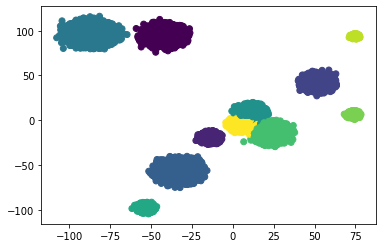

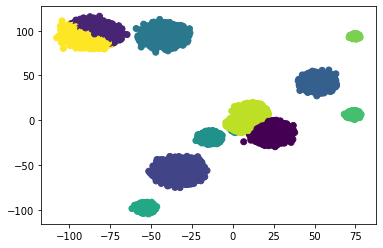

In [10]:
plot_clusters(*kmeans)
plot_clusters(*batch_kmeans)

### Zadanie * <a name="kmeans_task"></a>

## DBSCAN  <a name="DBSCAN"></a>
### Density-based spatial clustering of applications with noise 

DBSCAN prezentuje inne podejście do problemów analizy skupień, oparte na analizie gęstości.

Dwa podstawowe parametry:
 - $\epsilon$,
 - **minPts**

Sposób działania:

   1. Znajdź punkty w sąsiedztwie ($\epsilon$) każdego punktu, znajdź "punkty bazowe" (ang. core points) mające więcej niż **minPts** sąsiadów.
   2. Znajdź spójne składowe punktów bazowych, pomijając wszystkie pozostałe punkty,
   3. Przypisz każdy pozostały punkt do najbliższego klastra, jeśli jest w jego sąsiedztwie, w przeciwnym wypadku oznacz go jako szum/obserwację odstającą.
  


<img src="https://upload.wikimedia.org/wikipedia/commons/a/af/DBSCAN-Illustration.svg" alt="drawing" width="400"/>

In this diagram, minPts = 4. Point A and the other red points are core points, because the area surrounding these points in an ε radius contain at least 4 points (including the point itself). Because they are all reachable from one another, they form a single cluster. Points B and C are not core points, but are reachable from A (via other core points) and thus belong to the cluster as well. Point N is a noise point that is neither a core point nor directly-reachable.

Źródło ilustracji: https://en.wikipedia.org/wiki/DBSCAN

### Przykład <a name="DBSCAN_example"></a>

In [11]:
def _DBSCAN(X, eps=0.3):
    dbs = cluster.DBSCAN(eps=eps)
    dbs.fit(X)
    return X, dbs

Podstawowe parametry *sklearn.cluster.DBSCAN*: 

`eps` default=0.5  
`min_samples` default=5   
`metric` default = 'euclidean'  

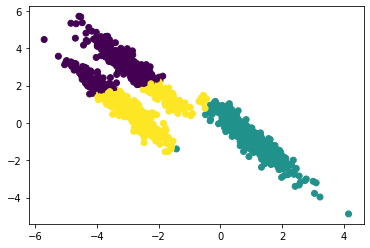

In [12]:
plot_clusters(*_KMeans(X_aniso, n_clusters=3))

In [ ]:
plot_clusters(*_DBSCAN(X_aniso), title="DBSCAN")

### Zadanie <a name="DBSCAN_task"></a>  

In [ ]:
plot_clusters(*_DBSCAN(noisy_circles[0]))

### Więcej <a name="DBSCAN_sources"></a>  

https://github.com/tirthajyoti/Machine-Learning-with-Python/blob/master/Clustering-Dimensionality-Reduction/DBScan_Clustering.ipynb

Przykład z dokumentacji: https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py

Estimated number of clusters: 3
Estimated number of noise points: 18
Homogeneity: 0.953
Completeness: 0.883
V-measure: 0.917
Adjusted Rand Index: 0.952
Adjusted Mutual Information: 0.916
Silhouette Coefficient: 0.626


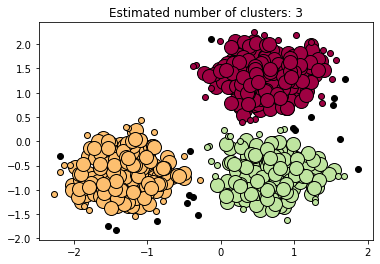

In [4]:
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler


# #############################################################################
# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4,
                            random_state=0)

X = StandardScaler().fit_transform(X)

# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()
hide_toggle()

## GMM (Gaussian Mixture Models) <a name="GMM"></a>

### Przykład <a name="GMM_example"></a>

In [14]:
parameters = {
    'alpha': 0.5,
    's': 30
}

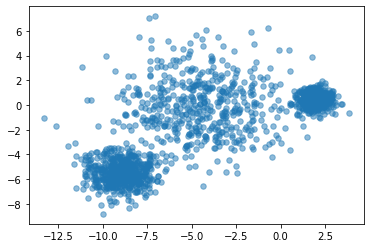

In [15]:
plt.scatter(varied[0][:,0], varied[0][:,1], **parameters)
plt.show()

Jak sobie poradzi DBSCAN?

In [ ]:
plot_clusters(*_DBSCAN(varied[0]), **parameters)

In [16]:
def _GMM(X, n_components, covariance_type='full'):
    gmm = mixture.GaussianMixture(n_components=n_components, covariance_type=covariance_type)
    gmm.fit(X)
    return X, gmm

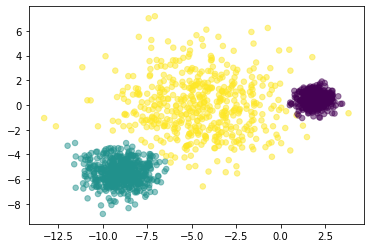

In [17]:
plot_clusters(*_GMM(varied[0], n_components=3), **parameters)

 DBSCAN Revisited, Revisited: Why and How You Should (Still) Use DBSCAN (2017): https://dl.acm.org/doi/10.1145/3068335